In [20]:
import numpy as np
import tensorflow as tf
import json
import math
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [21]:
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshape
x_test = x_test.reshape(10000,784)
org_x_test = x_test/255
# One Hot Encoding
y_test_1hot = np.array(to_categorical(y_test, 10), dtype=np.uint8)
# ref_model = tf.keras.models.load_model('saved_model/nn')

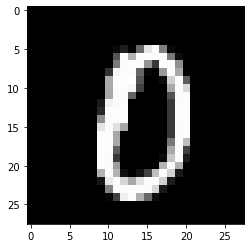

In [22]:
plt.imshow(x_test[55].reshape((28, 28)), cmap="gray")

In [23]:
ref_model = tf.keras.models.load_model("../nn/saved_model/nn")

In [44]:
%%timeit -r 1000
ref_model.predict(np.array(x_test), verbose=0)

948 ms ± 93 ms per loop (mean ± std. dev. of 100 runs, 1 loop each)


In [49]:
print(f"{948 / 10_000 * 1_000_000} ns pro prediction")

94800.0 ns pro prediction


In [24]:
def convert_vector_to_uint(v, bitlength):
    maxint = math.pow(2, bitlength) - 1
    # Normalise
    vmin = np.min(v)
    vmax = np.max(v)
    v = (v-vmin)/(vmax-vmin)
    # Use maximal uint8 range
    v = v * maxint
    return np.array(v, dtype=np.uint8)

# Stack: optional
weights = ref_model.layers[0].weights[0].numpy()
bias = ref_model.layers[0].bias.numpy()
weights = np.vstack((bias, weights))
weights_org = weights

# Convert
weight_bitlength = 8
conv_x_bitlength = 3
conv_weights = convert_vector_to_uint(weights, weight_bitlength)
conv_x_test = convert_vector_to_uint(x_test, conv_x_bitlength)

In [25]:
loss, acc = ref_model.evaluate(org_x_test, y_test_1hot)
print(f"Evaluation auf den Testdaten:\n\nLoss = {loss:.3f}\nAccuracy = {acc:.3f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.2805 - acc: 0.9226
Evaluation auf den Testdaten:

Loss = 0.281
Accuracy = 0.923


In [26]:
max_value = 2 ** conv_x_bitlength - 1 # 2^4 in this case equals 16, so we got a range from 0 - 15
max_value

7

In [27]:
def run_model(x, w):
    x = np.append([max_value], x) # 255 for bias cause 1 resembles 255 in uint max scale
    return np.dot(x,w)  # ! return value is uint64 in size

In [28]:
length = len(x_test)
org_acc_score = 0
conv_acc_score = 0
conv_score = 0
preds = ref_model.predict(org_x_test)

original_predictions = []
original_predictions_raw = []

converted_predictions = []
converted_predictions_raw = []

for i in range(length): 

    # TODO: print a confusion matrix
    converted_prediction_raw = run_model(conv_x_test[i], conv_weights).tolist()
    converted_prediction = int(np.argmax(converted_prediction_raw))

    original_prediction_raw = preds[i].tolist()
    original_prediction = int(np.argmax(original_prediction_raw))

    converted_predictions_raw.append(converted_prediction_raw)
    converted_predictions.append(converted_prediction)
    
    original_predictions_raw.append(original_prediction_raw)
    original_predictions.append(original_prediction)

    pred1 = converted_prediction
    pred2 = original_prediction

    if pred1 == np.argmax(y_test_1hot[i]): 
        conv_acc_score += 1
    if pred2 == np.argmax(y_test_1hot[i]): 
        org_acc_score += 1
    if pred1 == pred2:
        conv_score +=1

conv_acc = conv_acc_score/length
org_acc = org_acc_score/length
conv_score = conv_score/length
print(f"Conversion Accuracy: {conv_acc} \nOriginal Accuracy: {org_acc} \nConversion Success: {conv_score}") 

313/313 [==============================] - 1s 3ms/step
Conversion Accuracy: 0.9178 
Original Accuracy: 0.9226 
Conversion Success: 0.9839


In [29]:
conv_x_rev = np.flip(conv_x_test, axis=1)
conv_weights_rev = np.flip(conv_weights, axis=0)

In [30]:
conv_weights_rev.shape

(785, 10)

In [31]:
x_label_rev = np.flip(y_test, axis=0)
x_label_rev

array([6, 5, 4, ..., 1, 2, 7], dtype=uint8)

In [32]:
TEST_INDEX = 55

In [34]:
x_label_rev[TEST_INDEX]

0

In [13]:
result = ref_model.predict(np.array([np.flip(org_x_test, axis=1)[TEST_INDEX]]))
result

1/1 [==============================] - 0s 22ms/step


array([[2.081e-03, 5.254e-01, 1.349e-01, 1.637e-02, 1.192e-07, 1.811e-02,
        9.058e-02, 1.192e-07, 2.123e-01, 1.352e-04]], dtype=float16)

In [14]:
result.max()

0.5254

In [15]:
np.flip(org_x_test, axis=1)[42][90:100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.45098039, 0.99607843, 0.76078431, 0.        , 0.        ])

In [16]:
conv_x_rev[42][90:100]

array([0, 0, 0, 0, 0, 3, 6, 5, 0, 0], dtype=uint8)

In [29]:
data  = {
    'meta': {
        'conversion accuracy': conv_acc,
        'original accuracy': org_acc,
        'conversion error rate': conv_score,
        'weights bitlength': weight_bitlength,
        'inputs bitlength': conv_x_bitlength
    },
    'weights': conv_weights.tolist(),
    'inputs': conv_x_test.tolist(),
    "label": y_test.tolist(),
    "predictions": {
        "original": original_predictions,
        "original_raw": original_predictions_raw,
        "converted": converted_predictions,
        "converted_raw": converted_predictions_raw,
    }
}

with open('model_data.json', 'w') as f:
    json.dump(data, f)